# MODEL 1 - Simple ConvNet

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.python.data import AUTOTUNE
from tensorflow.keras import layers as kl
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks as cb
import tensorflow_addons as tfa

if os.getcwd().startswith("/Users"): os.chdir(os.getcwd().split("/notebooks", 1)[0])

from src.config.notebook_config import NotebookConfig
from src.evaluation.evaluation import Evaluation
from src.math.euclidian_distance import euclidian_distance
from src.data.dataset import dataset_v1_loader as dataset_loader
from src.evaluation.evaluation import Evaluation

from src.data.dataset.image_shape import ImageShape
from src.data.utility.tf_dataset_transformer import TfDatasetTransformer

%load_ext autoreload
%autoreload 2

# Config

In [14]:
MODEL_NAME = "model_1"

config = NotebookConfig(MODEL_NAME)
DATASET_LOADER = dataset_loader

BATCH_SIZE = 64

# Data Loading

In [15]:
train_dataset = DATASET_LOADER.load_train_v1()
val_dataset = DATASET_LOADER.load_validation_v1()

In [16]:
pair_tuples = list(map(lambda pair: (pair.image_a, pair.image_b, pair.similar), train_dataset.image_pairs))
pair_array = np.array(pair_tuples)


tf_dataset_transformer =  TfDatasetTransformer(image_shape=config.image_shape)

train_tf_dataset = tf_dataset_transformer.transform_to_tf_dataset(train_dataset, shuffle=True, shuffle_buffer_size=1024)\
                                         .cache("./tf_cache/train_dataset")\
                                         .batch(BATCH_SIZE)\
                                         .prefetch(AUTOTUNE)

val_tf_dataset = tf_dataset_transformer.transform_to_tf_dataset(val_dataset)\
                                         .cache("./tf_cache/val_dataset")\
                                         .batch(128)\
                                         .prefetch(AUTOTUNE)

# Model

In [20]:
def create_common_model() -> keras.Model:
    input = keras.Input(shape=config.image_shape.to_shape())
    x = kl.Conv2D(filters=64, kernel_size=7, strides=2, padding="valid", activation="relu")(input)
    x = kl.BatchNormalization()(x)
    x = kl.MaxPool2D(pool_size=3)(x)
    x = kl.Flatten()(x)
    return keras.Model(inputs=input, outputs=x)

def create_model() -> keras.Model:
    input_a = keras.Input(shape=config.image_shape.to_shape())
    input_b = keras.Input(shape=config.image_shape.to_shape())

    common_model = create_common_model()

    layer_a = common_model(input_a)
    layer_b = common_model(input_b)

    merge_layer = kl.Lambda(euclidian_distance)([layer_a, layer_b])
    merge_layer = kl.Dense(1, activation="sigmoid")(merge_layer)

    return keras.Model(inputs=[input_a, input_b], outputs=merge_layer, name=MODEL_NAME)


metric_f1 = tfa.metrics.f_scores.F1Score(num_classes=1, average="micro", name="f1-micro")

model = create_model()
model.compile(
    optimizer=optimizers.Adam(), loss=losses.CategoricalHinge(), metrics=["accuracy", metric_f1])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 82944)        9728        ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

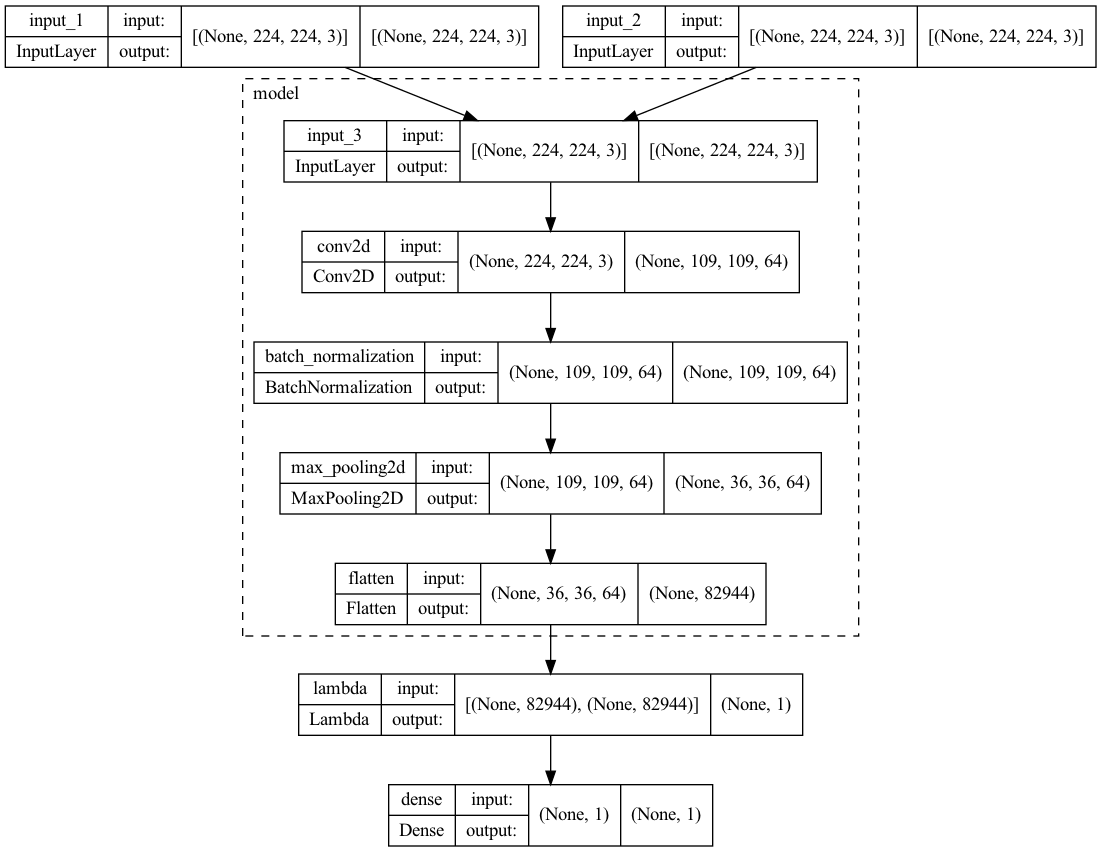

In [21]:
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
save_cb = cb.ModelCheckpoint(config.model_output_path, save_best_only=True)
tensorboard_cb = cb.TensorBoard(log_dir=config.tensorboard_log_dir)

history = model.fit(train_tf_dataset, epochs=20, workers=8, max_queue_size=20, validation_data=val_tf_dataset, callbacks=[save_cb, tensorboard_cb])

pd.DataFrame(history.history).plot()

In [23]:
import gc
gc.collect(2)#%%

33302

# Evaluation

In [ ]:
model: keras.Model = keras.models.load_model(config.saved_model_path, compile=False)
model.compile()

In [23]:
evaluation = Evaluation(dataset=val_dataset, image_shape=config.image_shape, model=model)

In [ ]:
evaluation.print_f1_report(threshold=0.5)
evaluation.print_separate_f1_reports(threshold=0.5)
evaluation.plot_roc()

In [ ]:
evaluation.show_images(range(8000, 8100))